In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Embedding, Flatten
import sklearn
from tensorflow.keras.optimizers import SGD, Adam

!pip install transformers
import transformers
from transformers import TFAutoModel, AutoTokenizer

import tensorflow_hub as hub

import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
nltk.download('stopwords')
nltk.download('punkt')
import tensorflow as tf

nltk_st = stopwords.words('english')

In [2]:
df_train = pd.read_csv('./train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('./test.csv', dtype={'id': np.int16})
df_train = df_train[-(df_train.text.duplicated(keep='first'))]
df_train = df_train.reset_index()
df_train=df_train.drop(['index'],axis=1)
df_train.sample(5)

,id,keyword,location,text,target
1976,2870,damage,"Lawrence, KS via Emporia, KS",Hey the #Royals love doing damage with 2 outs.,1
2430,3523,derailment,Chicagoland,CHICAGO FD\nSTILL &amp; BOX ALARM/EMS PLAN I \...,1
3763,5426,first%20responders,Roads/Trails Everywhere,RT RoadID: Thanks to Alex for his story &amp; ...,0
3603,5207,fatalities,Just Happy to Be Anywhere,.@KurtSchlichter Yep considering that *million...,1
4117,5929,harm,NaN,@TasteMyCupCakee lmfaooo hell nawh ?? yo ass ...,0


# Data visualization

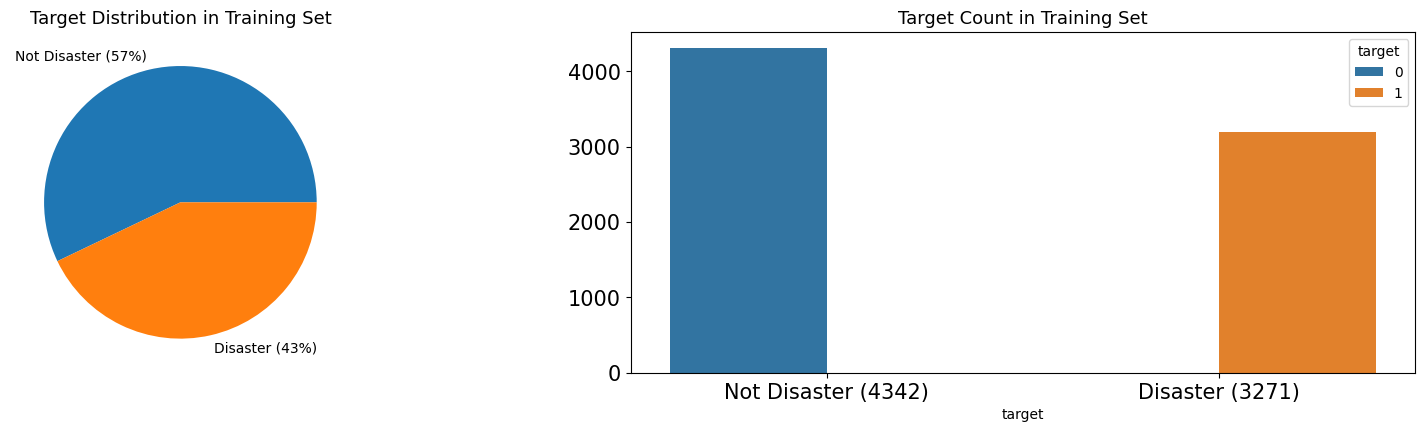

In [3]:
import seaborn as sns
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count().location.plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

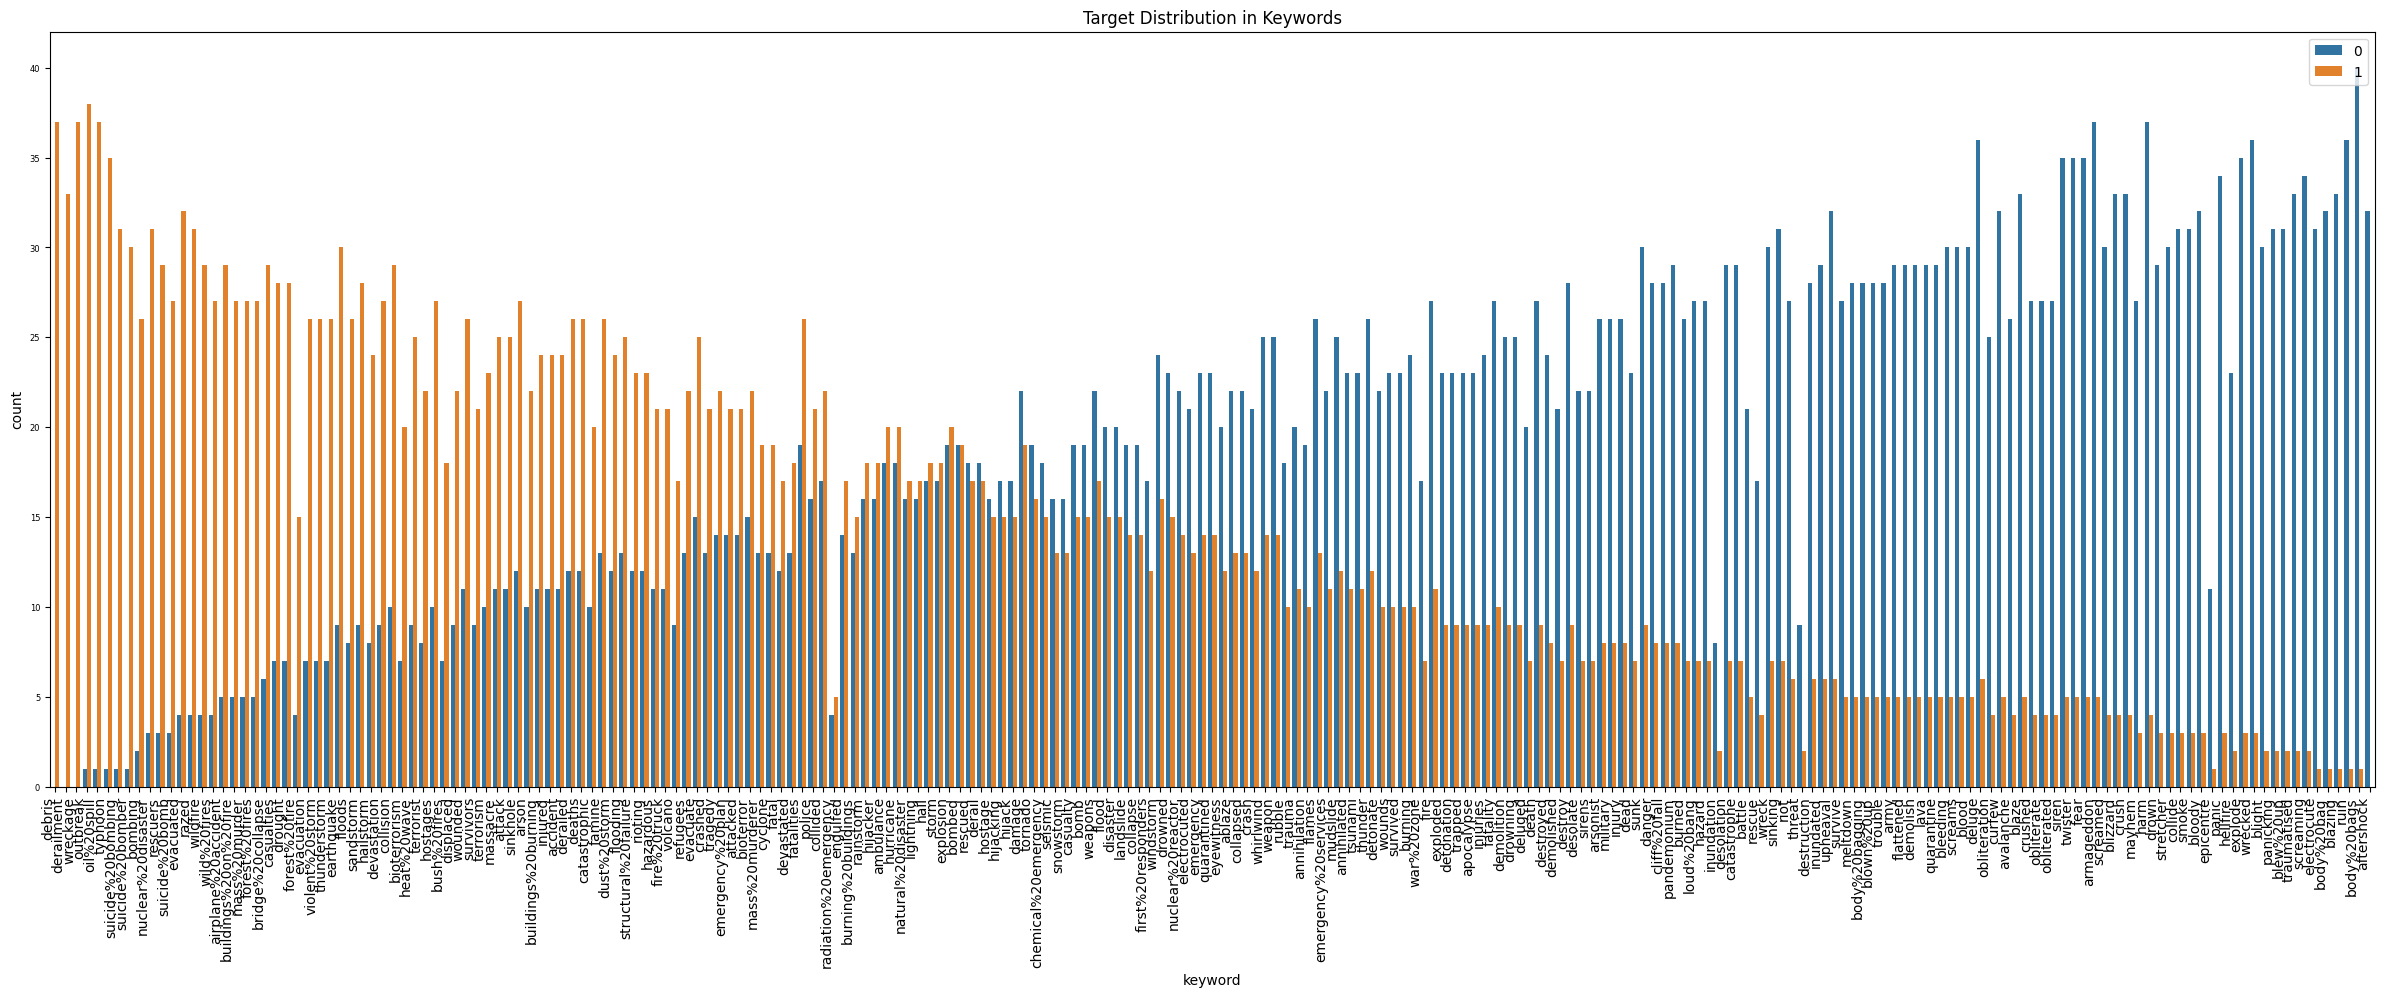

In [4]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(30,10), dpi=100)
sns.countplot(x=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])
plt.tick_params(axis='y', labelsize=6)
plt.xticks(rotation=90, ha='right')
plt.tick_params(axis='x', labelsize=10)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.show()
df_train.drop(columns=['target_mean'], inplace=True)

In [5]:

perfection = pd.read_csv('perfect_submission.csv')

In [6]:
df_train.keyword.fillna("unknown",inplace=True)
df_train.location.fillna("unknown",inplace=True)
df_test.keyword.fillna("unknown",inplace=True)
df_test.location.fillna("unknown",inplace=True)

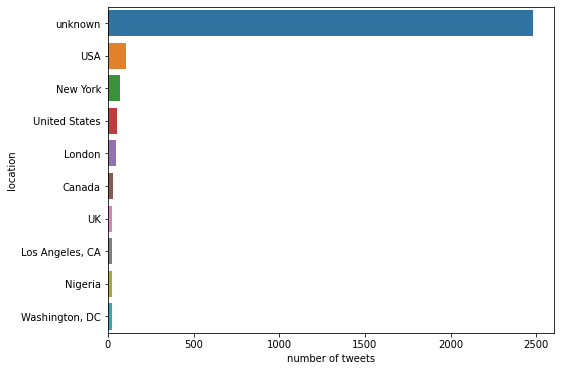

In [7]:
top20_loc = df_train.groupby(['location']).location.count().sort_values(ascending=False)[:10]
plt.figure(figsize = (8,6))
sns.barplot(x = top20_loc, y = top20_loc.index);
plt.xlabel('number of tweets');

# Text Cleaning

In [8]:
def remove_accents(raw_text):
    raw_text = re.sub(u"[àáâãäå]", '', raw_text)
    raw_text = re.sub(u"[èéêë]", '', raw_text)
    raw_text = re.sub(u"[ìíîï]", '', raw_text)
    raw_text = re.sub(u"[òóôõö]", '', raw_text)
    raw_text = re.sub(u"[ùúûü]", '', raw_text)
    raw_text = re.sub(u"[ýÿ]", '', raw_text)
    raw_text = re.sub(u"[ß]", '', raw_text)
    raw_text = re.sub(u"[ñ]", '', raw_text)
    return raw_text

In [9]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
def convert_abbrev(word):
    if word.lower() in abbreviations.keys():
      return abbreviations[word.lower()] 
    else:
      return word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [10]:
import unicodedata
def simplify(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

nltk.download('stopwords')
nltk.download('punkt')

nltk_st = stopwords.words('english')
nltk_st += ['us',"n't"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
def clean(tweet,http = True, punc = True, stop_w = True,abbv=True,simp=True):
    
    tweet = [word.lower() for word in word_tokenize(tweet)]
    tweet = ' '.join(tweet)
    
    if http is True:
      tweet = re.sub(r'http\S+', '', tweet)
    
    if stop_w is True:
      tweet = [word for word in word_tokenize(tweet) if not word.lower() in nltk_st]
      tweet = ' '.join(tweet)

    if abbv is True:
      tweet = convert_abbrev_in_text(tweet)

    if simp is True:
      tweet = remove_accents(tweet)
      tweet = simplify(tweet)
    
    

    if punc is True:
      tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    
    tweet = re.sub('new ',' ',tweet)
    tweet = re.sub('one ',' ',tweet)
    tweet = re.sub('via ',' ',tweet)
    tweet = re.sub('amp ',' ',tweet)

    tweet = re.sub("\s+",' ', tweet)

    return tweet


In [13]:
df_train['cleaned_text'] = df_train.text.apply(lambda x: clean(x))
df_test['cleaned_text'] = df_test.text.apply(lambda x: clean(x))
df_train.keyword = df_train.keyword.apply(lambda w: re.sub('%20',' ',w))
df_test.keyword = df_test.keyword.apply(lambda w: re.sub('%20',' ',w))

# Data visulization (continues) Word Cloud

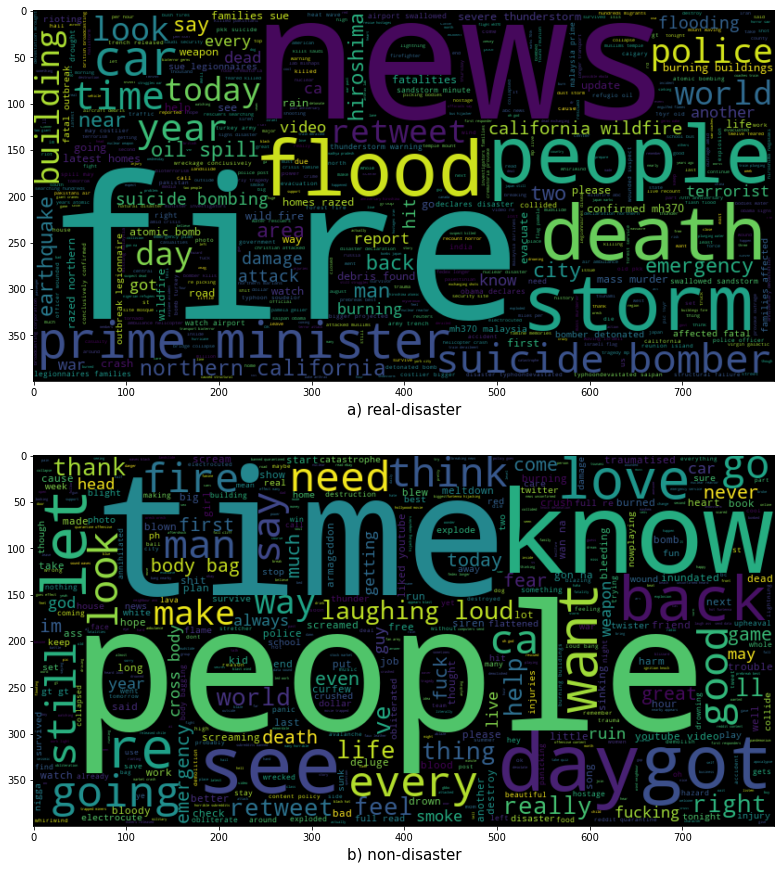

In [14]:
from wordcloud import WordCloud

plt.figure(figsize = (15,15)) 
plt.subplot(2,1,1) 
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(df_train[df_train.target == 1].cleaned_text))
plt.xlabel("a) real-disaster",fontsize = 15)
plt.imshow(wc , interpolation = 'bilinear')

plt.subplot(2,1,2) 
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(df_train[df_train.target == 0].cleaned_text))
plt.xlabel("b) non-disaster",fontsize = 15)
plt.imshow(wc , interpolation = 'bilinear')

# BERT Model

In [15]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [16]:
def tokenizeTweets(row):
    return tokenizer.convert_tokens_to_ids(['[CLS]']+tokenizer.tokenize(row.cleaned_text)+['[SEP]'] +tokenizer.tokenize(row.keyword) + ['[SEP]'])

df_train['tokenized_tweets'] = df_train.apply(lambda row : tokenizeTweets(row),axis=1)
df_test['tokenized_tweets'] = df_test.apply(lambda row : tokenizeTweets(row),axis=1)
max_len = max(len(max(df_train.tokenized_tweets, key = len)),len(max(df_test.tokenized_tweets, key = len)))
max_len

56

# Base Model

In [17]:
# max_len = 100
max_words = 10000

In [18]:
tokenizer = Tokenizer(num_words=max_words)

In [19]:
tokenizer.fit_on_texts(df_train.cleaned_text)
word_index = tokenizer.word_index
len(word_index)

21983

In [20]:
sequences = tokenizer.texts_to_sequences(df_train.cleaned_text)
X = pad_sequences(sequences, maxlen=max_len)
X.shape

(7503, 56)

In [21]:
X_test = tokenizer.texts_to_sequences(df_test.cleaned_text)
X_test = pad_sequences(X_test, maxlen=max_len)
X_test.shape

(3263, 56)

In [22]:
y = np.array(df_train['target']).reshape((-1,1))
y.shape


(7503, 1)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [24]:
def train(model):
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data =(X_val,y_val))
  return model

In [25]:
def base_line():
  #Dense
  model = Sequential([
      Embedding(max_words, 32, input_length=max_len),
      Flatten(),
      Dense(16, activation='relu'),
      Dropout(0.5),
      Dense(8, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
  ])
  model = train(model)
  y_pred_dense = model.predict(X_test)
  print(' Dense => f1 score of prediction: ', sklearn.metrics.f1_score(perfection.target, np.round(y_pred_dense), average = 'micro'))

  #LSTM
  model = Sequential([
      Embedding(max_words, 32, input_length=max_len),
      LSTM(32, return_sequences=True),
      LSTM(32),
      Dense(1, activation='sigmoid')
  ])
  model = train(model)
  y_pred_lstm = model.predict(X_test)
  print(' LSTM => f1 score of prediction: ', sklearn.metrics.f1_score(perfection.target, np.round(y_pred_lstm), average = 'micro'))
  return [y_pred_dense, y_pred_lstm]

In [26]:
[y_pred_dense, y_pred_lstm] = base_line()

Epoch 1/5
188/188 [==============================] - 5s 12ms/step - loss: 0.6757 - accuracy: 0.5771 - val_loss: 0.6470 - val_accuracy: 0.6429
Epoch 2/5
188/188 [==============================] - 2s 11ms/step - loss: 0.6257 - accuracy: 0.6306 - val_loss: 0.5941 - val_accuracy: 0.7515
Epoch 3/5
188/188 [==============================] - 2s 10ms/step - loss: 0.5527 - accuracy: 0.7086 - val_loss: 0.5011 - val_accuracy: 0.7748
Epoch 4/5
188/188 [==============================] - 2s 8ms/step - loss: 0.4779 - accuracy: 0.7786 - val_loss: 0.4721 - val_accuracy: 0.7815
Epoch 5/5
188/188 [==============================] - 2s 11ms/step - loss: 0.4113 - accuracy: 0.8281 - val_loss: 0.4771 - val_accuracy: 0.7801
 Dense => f1 score of prediction:  0.7919092859331903
Epoch 1/5
188/188 [==============================] - 15s 21ms/step - loss: 0.5793 - accuracy: 0.6966 - val_loss: 0.4800 - val_accuracy: 0.7761
Epoch 2/5
188/188 [==============================] - 2s 13ms/step - loss: 0.3837 - accuracy: 0

# Proposed Model with BERT

In [37]:
max_len = 60
tokenizer = AutoTokenizer.from_pretrained(model_name)
def encode(df):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text,keyword in zip(df.cleaned_text,df.keyword):
        text = tokenizer.tokenize(text)
        keyword = tokenizer.tokenize(keyword)
        # text = text[:max_len-2]
        input_sequence = ['[CLS]'] + text + ['[SEP]'] + keyword + ['[SEP]']

        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * (len(text) + 2) + [1] * (max_len - len(text) - 2 )
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)



def make_model():
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    bert_layer = TFAutoModel.from_pretrained(model_name,trainable=True)
    sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])[0]
    
    clf_output = sequence_output
    clf_output = GlobalAveragePooling1D()(clf_output)
    clf_output =  Dense(1024, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.01))(clf_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(optimizer = Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [53]:
# checkpoint = ModelCheckpoint('model.tf', monitor='val_accuracy',save_best_only=True)
model = make_model()
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 60)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
X = encode(df_train)
Y = df_train['target']
model.fit(X, Y, validation_split=0.2,
          batch_size=64, epochs = 2,
          # callbacks=[checkpoint]
          )

Epoch 1/2
94/94 [==============================] - 79s 542ms/step - loss: 8.9286 - accuracy: 0.7917 - val_loss: 8.5598 - val_accuracy: 0.8108
Epoch 2/2
94/94 [==============================] - 47s 503ms/step - loss: 8.1909 - accuracy: 0.8514 - val_loss: 7.9365 - val_accuracy: 0.8235


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# K = 2
# skf = StratifiedKFold(n_splits=K, random_state=1000, shuffle=True)

# for trn_idx, val_idx in skf.split(df_train.text,df_train['target']):
#     print("fold:")
#     X_trn=encode(df_train.loc[trn_idx])
#     y_trn=df_train.loc[trn_idx,'target']
#     X_val=encode(df_train.loc[val_idx])
#     y_val=df_train.loc[val_idx,'target']
#     model.fit(X_trn, y_trn, validation_data=(X_val,y_val), 
#           batch_size=32, epochs = 3)

In [56]:
X_test_encoded = encode(df_test)
y_pred_bert = model.predict(X_test_encoded)
y_pred = np.round(y_pred_bert)
print('The F1 score of prediction: ', sklearn.metrics.f1_score(perfection.target, y_pred.astype('int'), average = 'micro'))

The F1 score of prediction:  0.8280723260802942


In [57]:
cf_matrix=sklearn.metrics.confusion_matrix(perfection.target, y_pred.astype('int'))

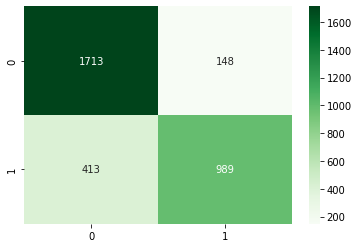

In [58]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True,fmt="d",cmap='Greens')

In [59]:
model_submission = pd.read_csv('perfect_submission.csv')
model_submission['target'] = np.round(y_pred_bert).astype('int')
model_submission.to_csv('model_submission.csv', index=False)
model_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
